In [1]:
import numpy as np
import os
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks
from keras.utils.vis_utils import plot_model
import keras.backend as K
import tensorflow as tf
from keras import initializers, layers

Using TensorFlow backend.


In [2]:
import keras.backend as K
import tensorflow as tf
from keras import initializers, layers
 
class Length(layers.Layer):
    def call(self, inputs, **kwargs):
        return K.sqrt(K.sum(K.square(inputs), -1))
 
    def compute_output_shape(self, input_shape):
        return input_shape[:-1]

In [3]:
class Mask(layers.Layer):
    def call(self, inputs, **kwargs):
        if type(inputs) is list: 
            assert len(inputs) == 2
            inputs, mask = inputs
        else:
            x = inputs
 
            x = (x - K.max(x, 1, True)) / K.epsilon() + 1
            mask = K.clip(x, 0, 1)
 
        inputs_masked = K.batch_dot(inputs, mask, [1, 1])
        return inputs_masked
 
    def compute_output_shape(self, input_shape):
        if type(input_shape[0]) is tuple:
            return tuple([None, input_shape[0][-1]])
        else:
            return tuple([None, input_shape[-1]])

In [4]:
def squash(vectors, axis=-1):
    s_squared_norm = K.sum(K.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm) / K.sqrt(s_squared_norm)
    return scale * vectors

In [5]:
class CapsuleLayer(layers.Layer):
    def __init__(self, num_capsule, dim_vector, num_routing=3,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_vector = dim_vector
        self.num_routing = num_routing
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
 
    def build(self, input_shape):
        assert len(input_shape) >= 3
        self.input_num_capsule = input_shape[1]
        self.input_dim_vector = input_shape[2]
 
        self.W = self.add_weight(shape=[self.input_num_capsule, self.num_capsule, self.input_dim_vector, self.dim_vector],
                                 initializer=self.kernel_initializer,
                                 name='W')
 
        self.bias = self.add_weight(shape=[1, self.input_num_capsule, self.num_capsule, 1, 1],
                                    initializer=self.bias_initializer,
                                    name='bias',
                                    trainable=False)
        self.built = True
 
    def call(self, inputs, training=None):
        inputs_expand = K.expand_dims(K.expand_dims(inputs, 2), 2)
 
        inputs_tiled = K.tile(inputs_expand, [1, 1, self.num_capsule, 1, 1])
 
        inputs_hat = tf.scan(lambda ac, x: K.batch_dot(x, self.W, [3, 2]),
                             elems=inputs_tiled,
                             initializer=K.zeros([self.input_num_capsule, self.num_capsule, 1, self.dim_vector]))
 
        assert self.num_routing > 0, 'The num_routing should be > 0.'
        for i in range(self.num_routing):
            c = tf.nn.softmax(self.bias, dim=2)
 
            outputs = squash(K.sum(c * inputs_hat, 1, keepdims=True))
 
 
            if i != self.num_routing - 1:
                self.bias += K.sum(inputs_hat * outputs, -1, keepdims=True)
        return K.reshape(outputs, [-1, self.num_capsule, self.dim_vector])
 
    def compute_output_shape(self, input_shape):
        return tuple([None, self.num_capsule, self.dim_vector])

def PrimaryCap(inputs, dim_vector, n_channels, kernel_size, strides, padding):
    output = layers.Conv2D(filters=dim_vector*n_channels, kernel_size=kernel_size, strides=strides, padding=padding)(inputs)
    outputs = layers.Reshape(target_shape=[-1, dim_vector])(output)
    return layers.Lambda(squash)(outputs)

In [6]:
from keras import layers, models
from keras import backend as K
from keras.utils import to_categorical
def CapsNet(input_shape, n_class, num_routing):
    x = layers.Input(shape=input_shape)
    conv1 = layers.Conv2D(filters=256, kernel_size=9, strides=1, padding='valid', activation='relu', name='conv1')(x)
    primarycaps = PrimaryCap(conv1, dim_vector=8, n_channels=32, kernel_size=9, strides=2, padding='valid')
    digitcaps = CapsuleLayer(num_capsule=n_class, dim_vector=16, num_routing=num_routing, name='digitcaps')(primarycaps)
    out_caps = Length(name='out_caps')(digitcaps)
 
    y = layers.Input(shape=(n_class,))
    masked = Mask()([digitcaps, y])
    x_recon = layers.Dense(512, activation='relu')(masked)
    x_recon = layers.Dense(1024, activation='relu')(x_recon)
    x_recon = layers.Dense(784, activation='sigmoid')(x_recon)
    x_recon = layers.Reshape(target_shape=[28, 28, 1], name='out_recon')(x_recon)
 
    return models.Model([x, y], [out_caps, x_recon])

In [7]:
def margin_loss(y_true, y_pred):
    L = y_true * K.square(K.maximum(0., 0.9 - y_pred)) + \
    0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.1))
    return K.mean(K.sum(L, 1))

In [8]:
model = CapsNet(input_shape=[28, 28, 1],
                n_class=15,
                num_routing=3)
model.summary()
try:
    plot_model(model, to_file='model.png', show_shapes=True)
except Exception as e:
    print('No fancy plot {}'.format(e))




Instructions for updating:
dim is deprecated, use axis instead
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 20, 20, 256)  20992       input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 6, 6, 256)    5308672     conv1[0][0]                      
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 1152, 8)      0           conv2d_1[0][0]                   
___________________________________________

In [9]:
from sklearn.model_selection import train_test_split
train_data = np.load("../../1_data/train_data.npy")
train_label = np.load("../../1_data/train_label.npy")
print("train_data.shape=", train_data.shape)
print("train_label.shape=", train_label.shape)

train_data.shape= (3000, 1, 28, 28)
train_label.shape= (3000, 15)


In [11]:
def onehot_to_str(label):
    """
    ワンホットベクトル形式のラベルをカタカナ文字に変換する
    """
    dic_katakana = {"a":0,"i":1,"u":2,"e":3,"o":4,"ka":5,"ki":6,"ku":7,"ke":8,"ko":9,"sa":10,"si":11,"su":12,"se":13,"so":14}
    label_int = np.argmax(label)
    for key, value in dic_katakana.items():
        if value==label_int:
            return key
X=[]
Y=[]
n = 10
data = train_data
for i in range(len(data)):
     # 画像読み込み
    data = np.load("../../1_data/train_data.npy") 
    label = np.load("../../1_data/train_label.npy")  
    data = data[i:i+1]
    label = label[i:i+1]
    label_katakana = onehot_to_str(label)

    # 軸をN,H,W,Cに入れ替え
    data = data.transpose(0,2,3,1)

    # ImageDataGeneratorのオブジェクト生成
    datagen = ImageDataGenerator(
        rescale=1./255,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range = 0.1,
        shear_range = 0.2,
        rotation_range = 15
    )

    # 生成後枚数
    if label_katakana in ["a","i","u","e","o"]:
        num_image = 7*n
    else:
        num_image = 4*n

    # 生成
    g = datagen.flow(data)
    for i in range(num_image):
            batches = g.next()
            X.append(batches)
            Y.append(label)
X = np.array(X)
Y = np.array(Y)
X2 = np.squeeze(X, 1).copy()
Y2 = np.squeeze(Y, 1).copy()
print(X2.shape)

(150000, 28, 28, 1)


In [12]:
# 正規化
X2 = (X2 - X2.min()) / X2.max()
X2 = X2.astype('float32')
print("train_data.shape=", X2.shape)
x_train, x_test, y_train, y_test = train_test_split(X2, Y2, test_size=0.3, random_state=1234,shuffle=True)
print(x_train.shape, y_test.shape)

train_data.shape= (150000, 28, 28, 1)
(105000, 28, 28, 1) (45000, 15)


In [13]:
def train(model, data, epoch_size_frac=1.0):
 
    (x_train, y_train), (x_test, y_test) = data
 
    log = callbacks.CSVLogger('log.csv')
    checkpoint = callbacks.ModelCheckpoint('weights-{epoch:02d}.h5',
                                           save_best_only=True, save_weights_only=True, verbose=1)
    lr_decay = callbacks.LearningRateScheduler(schedule=lambda epoch: 0.001 * np.exp(-epoch / 10.))
 
    model.compile(optimizer='adam',
                  loss=[margin_loss, 'mse'],
                  loss_weights=[1., 0.0005],
                  metrics={'out_caps': 'accuracy'})
 
    # -----------------------------------Begin: Training with data augmentation -----------------------------------#
    def train_generator(x, y, batch_size, shift_fraction=0.):
        train_datagen = ImageDataGenerator(width_shift_range=shift_fraction,
                                           height_shift_range=shift_fraction)
        generator = train_datagen.flow(x, y, batch_size=batch_size)
        while 1:
            x_batch, y_batch = generator.next()
            yield ([x_batch, y_batch], [y_batch, x_batch])
 
    model.fit_generator(generator=train_generator(x_train, y_train, 64, 0.1),
                        steps_per_epoch=int(epoch_size_frac*y_train.shape[0] / 64),
                        epochs=1,
                        validation_data=[[x_test, y_test], [y_test, x_test]],
                        callbacks=[log, checkpoint, lr_decay])
    # -----------------------------------End: Training with data augmentation -----------------------------------#
 
    model.save_weights('trained_model.h5')
    print('Trained model saved to \'trained_model.h5\'')
 
    return model

In [14]:
train(model=model, data=((x_train, y_train), (x_test, y_test)), epoch_size_frac = 8.0)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/1
13125/13125 [==============================] - 2891s 220ms/step - loss: 0.0649 - out_caps_loss: 0.0649 - out_recon_loss: 0.0920 - out_caps_acc: 0.9401 - val_loss: 0.0212 - val_out_caps_loss: 0.0211 - val_out_recon_loss: 0.0925 - val_out_caps_acc: 0.9878

Epoch 00001: val_loss improved from inf to 0.02118, saving model to weights-01.h5
Trained model saved to 'trained_model.h5'


In [15]:
def combine_images(generated_images):
    num = generated_images.shape[0]
    width = int(np.sqrt(num))
    height = int(np.ceil(float(num)/width))
    shape = generated_images.shape[1:3]
    image = np.zeros((height*shape[0], width*shape[1]),
                     dtype=generated_images.dtype)
    for index, img in enumerate(generated_images):
        i = int(index/width)
        j = index % width
        image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1]] = \
            img[:, :, 0]
    return image
 
def test(model, data):
    x_test, y_test = data
    y_pred, x_recon = model.predict([x_test, y_test], batch_size=100)
    print('-'*50)
    print('Test acc:', np.sum(np.argmax(y_pred, 1) == np.argmax(y_test, 1))/y_test.shape[0])
 
    import matplotlib.pyplot as plt
    from PIL import Image
 
    img = combine_images(np.concatenate([x_test[:50],x_recon[:50]]))
    image = img * 255
    Image.fromarray(image.astype(np.uint8)).save("real_and_recon.png")
    print()
    print('Reconstructed images are saved to ./real_and_recon.png')
    print('-'*50)
    plt.imshow(plt.imread("real_and_recon.png", ))
    plt.show()

--------------------------------------------------
Test acc: 0.9877555555555556

Reconstructed images are saved to ./real_and_recon.png
--------------------------------------------------


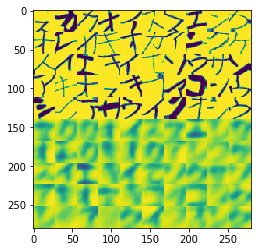

In [17]:
test(model=model, data=(x_test, y_test))